## Imports

In [1]:
!pip install numpy_financial

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None, 'display.max_columns', None)

import math
import scipy
import random

import time
import datetime as dt

import csv
import numpy_financial as npf

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Google Drive path
path = '/content/drive/My Drive/NYCDSA/lending_club/'  

Mounted at /content/drive


## Load relevant data

In [5]:
df = pd.read_csv(path+f'features/df_master.csv')
df.set_index('id', inplace=True)

# convert csv strings to datetime types
df.issue_d      = pd.to_datetime(df.issue_d,      infer_datetime_format=True)  
df.last_pymnt_d = pd.to_datetime(df.last_pymnt_d, infer_datetime_format=True) 

df.sample(3)

,issue_d,desc,title,application_type,purpose,grade,sub_grade,term,loan_amnt,int_rate,installment,initial_list_status,disbursement_method,addr_state,zip_code,home_ownership,emp_length,emp_title,annual_inc,verification_status,fico_range_high,fico_range_low,delinq_2yrs,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,loan_status,funded_amnt,total_pymnt,last_pymnt_d,recoveries,year_months,_good,_has_desc,_credit_hist
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
121909160,2017-11-01,NaN,Debt consolidation,Individual,debt_consolidation,D,D1,60 months,10000.0,17.09,249.01,w,Cash,CA,958xx,MORTGAGE,2 years,RN,95000.0,Not Verified,714.0,710.0,1.0,16.20,1997-08-01,23.0,1.0,8559.0,27.1,Fully Paid,10000.0,12027.429800,2019-02-01,0.0,2017_11,1,0,20.0
25516793,2014-08-01,NaN,Debt consolidation,Individual,debt_consolidation,D,D5,60 months,16975.0,18.24,433.28,f,Cash,FL,347xx,MORTGAGE,10+ years,lab tech,49296.0,Not Verified,714.0,710.0,0.0,34.81,2003-02-01,11.0,0.0,7459.0,42.9,Charged Off,16975.0,19209.420000,2017-06-01,4477.9,2014_08,0,0,11.0
46613354,2015-05-01,NaN,Debt consolidation,Individual,debt_consolidation,C,C1,60 months,12125.0,12.29,271.50,w,Cash,WY,820xx,RENT,2 years,Admin Assistant,41000.0,Source Verified,779.0,775.0,0.0,36.77,2000-05-01,11.0,0.0,4498.0,19.4,Fully Paid,12125.0,15039.965485,2017-10-01,0.0,2015_05,1,0,15.0


In [6]:
cf_cols = [
    '_good',
    'loan_status',
    'issue_d',   
    'loan_amnt', 
    'installment',
    'int_rate',  # for reference purposes
    'sub_grade', # for reference purposes  
    'term',
    'funded_amnt',
    'total_pymnt',
    'last_pymnt_d',
    'recoveries',
]

In [7]:
cf = df[cf_cols]
cf.head(2)

,_good,loan_status,issue_d,loan_amnt,installment,int_rate,sub_grade,term,funded_amnt,total_pymnt,last_pymnt_d,recoveries
id,,,,,,,,,,,,
369654,0,Does not meet the credit policy. Status:Charge...,2009-01-01,7000.0,250.49,17.26,F1,36 months,7000.0,1289.410000,2009-05-01,289.17
371779,1,Fully Paid,2009-01-01,10000.0,342.29,14.11,D1,36 months,10000.0,12322.379056,2012-01-01,0.00


In [8]:
cf.shape

(1345100, 12)

## Loan life and Loan type

Classify loans into three types:
- paid at maturity ('normal')
- defaulted
- pre-paid


In [9]:
cf['life'] = np.round((cf.last_pymnt_d - cf.issue_d) /np.timedelta64(1, 'M')).astype(int)

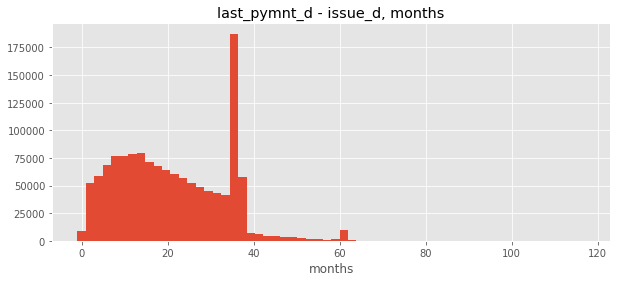

In [10]:
plt.figure(figsize=(10,4))
plt.hist(cf.life, bins=60)
plt.title('last_pymnt_d - issue_d, months')
plt.xlabel('months')
plt.show()

In [11]:
# some loans have 0 life and some even -1
cf.life[cf.life<=0].value_counts()

 0    9010
-1      23
Name: life, dtype: int64

In [12]:
# 0 and -1 life probably mean technical glitches, replace with life=1
cf['life'] = np.maximum(cf['life'], 1)

In [13]:
cf.term.replace({' 36 months':36, ' 60 months':60}, inplace=True)
cf['loan_type'] = cf.apply(lambda row: 'default' if (row._good==0) else\
                           'early' if (row.life<row.term) else 'normal', axis=1)

In [14]:
# 63% of the loans are paid early!
# many are paid back within a year - refinancing?
cf.loan_type.value_counts(normalize=True)

early      0.636352
default    0.199767
normal     0.163881
Name: loan_type, dtype: float64

In [15]:
# Build loan distribution by type within subgrades
sub_grades = sorted(list(set(cf.sub_grade)))
df_report = pd.DataFrame()
report_df = pd.DataFrame(columns=['normal', 'early', 'default'])
for sub_grade in sub_grades:
    vc = cf[cf.sub_grade==sub_grade].loan_type.value_counts()
    report_df.loc[sub_grade] = [vc['normal'], vc['early'], vc['default']]
# report_df    

<Figure size 864x288 with 0 Axes>

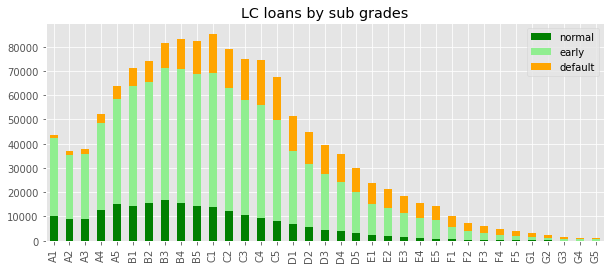

In [16]:
# visualize loan distribution by type
plt.figure(figsize=(12,4))
report_df.loc[:,['normal', 'early', 'default']].plot.bar(stacked=True, 
                                                          color=['green', 'lightgreen','orange'],
                                                         figsize=(10,4))
plt.title('LC loans by sub grades')
plt.show()

## Produce CF for each loan

In [17]:
# Produce all available timesteps (months in LC data)
cf_dates = list(set(cf.issue_d) | set(cf.last_pymnt_d))
cf_dates.sort()
assert len(cf_dates)==123  # verify 123 monthly dates
cf_dates

[Timestamp('2009-01-01 00:00:00'),
 Timestamp('2009-02-01 00:00:00'),
 Timestamp('2009-03-01 00:00:00'),
 Timestamp('2009-04-01 00:00:00'),
 Timestamp('2009-05-01 00:00:00'),
 Timestamp('2009-06-01 00:00:00'),
 Timestamp('2009-07-01 00:00:00'),
 Timestamp('2009-08-01 00:00:00'),
 Timestamp('2009-09-01 00:00:00'),
 Timestamp('2009-10-01 00:00:00'),
 Timestamp('2009-11-01 00:00:00'),
 Timestamp('2009-12-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2010-02-01 00:00:00'),
 Timestamp('2010-03-01 00:00:00'),
 Timestamp('2010-04-01 00:00:00'),
 Timestamp('2010-05-01 00:00:00'),
 Timestamp('2010-06-01 00:00:00'),
 Timestamp('2010-07-01 00:00:00'),
 Timestamp('2010-08-01 00:00:00'),
 Timestamp('2010-09-01 00:00:00'),
 Timestamp('2010-10-01 00:00:00'),
 Timestamp('2010-11-01 00:00:00'),
 Timestamp('2010-12-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2011-02-01 00:00:00'),
 Timestamp('2011-03-01 00:00:00'),
 Timestamp('2011-04-01 00:00:00'),
 Timestamp('2011-05-

Master function that takes loan id  and produces monthly cash flows

In [18]:
def get_cfs(loan_id, recovery_lag=6):
    """produce the lifetime CF for 3 loan types:
        - early
        - normal (contractual)
        - default
    """
    loan_type, loan_amnt, installment, total_pymnt, recoveries, life, term = cf.loc[loan_id,\
    ['loan_type', 'loan_amnt', 'installment', 'total_pymnt', 'recoveries', 'life', 'term']]

    periods = len(cf_dates)
    # identify the issue_d column as a starting position for CFs
    start_period = cf_dates.index(cf.loc[loan_id, 'issue_d'])

    cfs = list(np.zeros(start_period)) + [-loan_amnt]
    
    if loan_type=='early':
        # assume regular installments and one lump sum at the end
        tail = total_pymnt - (life-1)*installment
        cfs += [installment for _ in range(life-1)] + [tail]

    if loan_type=='normal':  
        # some good loans last longer than term (~1-2 months)
        # but some others have final payment 6 months (and even 2 years) late
        # for such cases, assume regular installments for all but the last payment 
        tail = total_pymnt - (term-1)*installment
        cfs += [installment for _ in range(term-1)] + [0 for _ in range(life-term)] + [tail]

    if loan_type=='default':  
        # regular installments * life ALMOST always equals total_payments-recoveries
        # --> last_payment_d is NOT the recovery date, it's the last REGULAR payment date
        # i.e. regular installments are paid until last_payment_d, then stop
        # assume a recovery_lag time span to collect any recoveries
        
        norm_term = int((total_pymnt-recoveries) // installment)
        if norm_term>life:
            norm_term=int(life)
            installment=(total_pymnt-recoveries)/norm_term

        tail = (total_pymnt-recoveries) % installment

        # make sure the last tail payment does not come later the last timestep available
        cfs += [installment for _ in range(norm_term)]
        if len(cfs)<periods: 
            cfs += [tail]
        else:
            cfs[-1]+=tail
        if life>norm_term: 
            cfs += list(np.zeros(life-norm_term-1))

        # add recoveries (last CF) after recovery_lag (provided it is within 123 timesteps)
        if recoveries > 0:
            if periods-len(cfs)==0:
                cfs[-1]+=recoveries
            else:
                cfs += list(np.zeros(min(recovery_lag,periods-len(cfs))-1)) + [recoveries]

    assert len(cfs)<=periods
    # pad the cash flows to match the entire coverage period (123 months) 
    cfs = np.pad(cfs, (0, periods-len(cfs)))
    
    # take LC 1% commission from all positive cash flows
    LC_COMM = 0.01
    cfs = np.where(cfs>0, cfs*(1-LC_COMM), cfs)

    return cfs


In [19]:
# produce a CF file for specific loan_ids
# Master CF file is produced by setting loan_ids = cf.index

def write_cf_master(loan_ids):

    tic = time.time()
    output_file = f'cf_{int(time.time())}.csv'

    with open(path+f'cf/{output_file}', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(['id']+list(cf_dates)) # write headers

        for i, loan_id in enumerate(loan_ids):
            try:
                cfs = get_cfs(loan_id)
                assert len(cf_dates)==len(cfs)
                writer.writerow([loan_id]+list(cfs))
            except:
                print('ERROR. loan id:', loan_id)
            if (i+1)%1_000==0:
                print(f'\r{100*i/len(cf.index):.1f}% complete \t{time.time()-tic:.1f} sec', end='')

# write_cf_master(cf.index)

## Uninformed IRR

In [20]:
# read Master CF file (~0.8 GB)
tic = time.time()
mf = pd.read_csv(path+'cf/'+'cf_master_1.csv')
mf.set_index('id',inplace=True)
print(f'loaded in {time.time()-tic:.1f} sec')

loaded in 19.6 sec


In [21]:
mf.head()

,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,2012-10-01 00:00:00,2012-11-01 00:00:00,2012-12-01 00:00:00,2013-01-01 00:00:00,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-04-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-07-01 00:00:00,2013-08-01 00:00:00,2013-09-01 00:00:00,2013-10-01 00:00:00,2013-11-01 00:00:00,2013-12-01 00:00:00,2014-01-01 00:00:00,2014-02-01 00:00:00,2014-03-01 00:00:00,2014-04-01 00:00:00,2014-05-01 00:00:00,2014-06-01 00:00:00,2014-07-01 00:00:00,2014-08-01 00:00:00,2014-09-01 00:00:00,2014-10-01 00:00:00,2014-11-01 00:00:00,2014-12-01 00:00:00,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,2015-07-01 00:00:00,2015-08-01 00:00:00,2015-09-01 00:00:00,2015-10-01 00:00:00,2015-11-01 00:00:00,2015-12-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00,2016-12-01 00:00:00,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
372540,-15000.0,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,496.9800,9281.70884,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
373376,-5000.0,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.93430,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,161.9343,1670.824552,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
371589,-4200.0,137.2734,137.2734,137.2734,137.2734,137.2734,137.2734,137.2734,137.2734,137.273

In [22]:
# Verify that the Master CF file has all loans, all periods
mf.shape

(1345100, 123)

In [23]:
# Helper functions to get from monthly IRRs to annual
def annualize_ret(monthly_ret):
    return (1+monthly_ret)**12-1
    
def portfolio_irr(loan_ids):
    monthly_irr =  npf.irr(mf.loc[loan_ids].apply(sum))
    return (1+monthly_irr)**12-1        

In [24]:
# Bootstrap: Sample N loans randomly for B times
# calculate the  IRR for the entire cash flow generated by the sample
B = 20
N = 1_000  # each time, sample N loans randomly


# calculate the randomized IRR for the entire loan universe:  1.26%
irrs = np.zeros(B)
for b in range(B):
    ids = random.sample(list(cf.index), 1_000)  
    irrs[b] = annualize_ret(npf.irr(mf.loc[ids].apply(sum)))  
total_irr, total_std = np.nanmean(irrs), np.nanstd(irrs)
total_irr, total_std

(0.011929669655441405, 0.009868472633804073)

In [25]:
# Calculate randomized bootstrapped IRRs within each sub_grade
report_df = pd.DataFrame(columns=[f'mean_B{B}', f'std_B{B}'])
report_df

sub_grades = sorted(list(set(cf.sub_grade)))
for sub_grade in sub_grades:
    
    loan_ids = cf[cf.sub_grade==sub_grade].index

    irrs = np.zeros(B)    
    for b in range(B):
        ids = random.sample(list(loan_ids), 1_000)  
        irrs[b] = annualize_ret(npf.irr(mf.loc[ids].apply(sum)))  
    
    report_df.loc[sub_grade] = [np.nanmean(irrs), np.nanstd(irrs)]
report_df    

,mean_B20,std_B20
A1,0.032534,0.003767
A2,0.035695,0.003962
A3,0.038026,0.005710
A4,0.036413,0.005025
A5,0.038542,0.003675
B1,0.030497,0.007523
B2,0.040387,0.006792
B3,0.043176,0.005823
B4,0.039149,0.007057
B5,0.026122,0.008082


In [26]:
# visualize bootstrapped IRRs within each subgrade
def plot_irr_sub_grades(report_df, B, N):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)

    ax.axhline(0, color='grey')
    irr_mean = report_df[f'mean_B{B}']
    irr_std  = report_df[f'std_B{B}']
    
    ax.plot(irr_mean, color='r', label='actual realized IRR')
    ax.fill_between(range(len(sub_grades)), 
                    irr_mean-2*irr_std, 
                    irr_mean+2*irr_std, color='red', alpha=.2)
    ax.set_xticks(range(len(sub_grades)))
    ax.set_ylim([-0.2,0.1])
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    ax.set_title('Bootstrapped 1000 loans IRR')
    ax.legend(loc='upper left')
    plt.show()

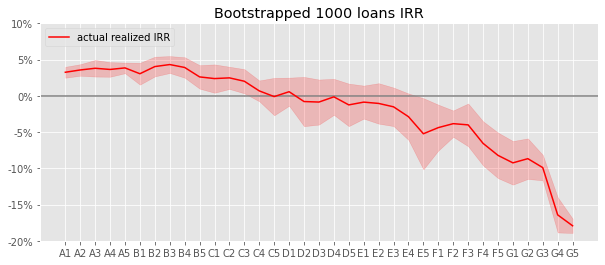

In [27]:
plot_irr_sub_grades(report_df, B, N)

## Classifier-informed IRRs

Can we achieve higher IRRs by applying a classifier to avoid defaults?

In [28]:
# load within-subgrade predictions
y_hat = pd.read_csv(path+'features/'+'per_grade_predictions_random_1592537716.csv')
y_hat.set_index('id', inplace=True)
y_hat = pd.merge(y_hat, cf.sub_grade, how='left', left_index=True, right_index=True)
y_hat.tail()

,_good,p,sub_grade
id,,,
41101897,1,0.457987,E5
66435453,0,0.704820,E5
75357921,1,0.470924,E5
129466073,1,0.646249,E5
88505232,1,0.635022,E5


In [29]:
tic = time.time()

# choose selectivity levels
quantiles = [0.01, 0.1,0.5,1]

B = 20
sub_sample = 0.8

reports = {}
sub_grades = sorted(list(set(y_hat.sub_grade)))

for q in quantiles:
    # for each selectivity level, produce a report with Bootsrapped IRR
    report_df = pd.DataFrame(columns=['total', 'filtered', 'mean_B', 'std_B'])
    
    for sub_grade in sub_grades:
        # for each subgrade, calculate the Bootsrapped IRR
        y_hat_grade = y_hat[y_hat.sub_grade==sub_grade].sort_values(by='p', ascending=False)
        q_len = int(q*len(y_hat_grade))
        indices = list(y_hat_grade[:q_len].index)
        irrs = np.zeros(B)    

        for b in range(B):
            ids = random.sample(list(indices), min(2000,int(sub_sample*q_len)))
            irrs[b] = annualize_ret(npf.irr(mf.loc[ids].apply(sum)))  
        
        report_df.loc[sub_grade] = [len(y_hat_grade), q_len, np.mean(irrs), np.std(irrs)]
        print(f'\r Quantile={q} \t sub_grade={sub_grade} \t {time.time()-tic:.1f} sec', end='')
    
    reports[q]=report_df

 Quantile=1 	 sub_grade=E5 	 55.8 sec

In [30]:
# Visualize the bootsrapped IRRs per subgrade
# Uninformed vs classifier-informed choice
def plot_subgrade_irr(reports):

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    ax.axhline(0, color='grey')

    for q in reports: 
        irr_mean = reports[q].mean_B
        irr_std  = reports[q].std_B
        ax.plot(irr_mean, label='all loans' if q==1 else f'classified top {100*q:.0f}%')
        ax.fill_between(range(len(sub_grades)), 
                        irr_mean-2*irr_std, 
                        irr_mean+2*irr_std, alpha=.2)
    ax.set_xticks(range(len(sub_grades)))
    ax.set_title('Within-subgrade classification. Bootstrapping IRR')
    ax.set_ylim(-0.1,0.2)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    ax.legend(loc='lower left')
    plt.show()

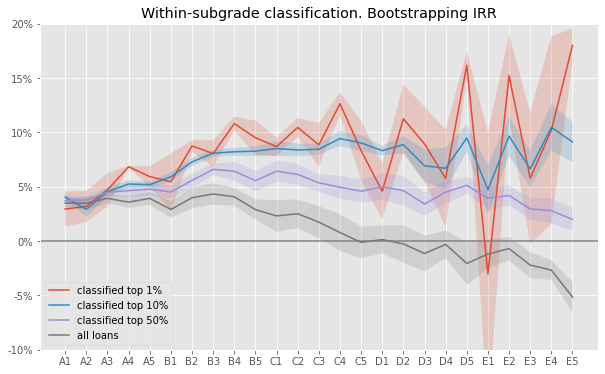

In [31]:
plot_subgrade_irr(reports)